<a href="https://colab.research.google.com/github/ckodser/RFCL/blob/main/tresholdActivation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
batch_size = 256
# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([256, 1, 28, 28])
Shape of y:  torch.Size([256]) torch.int64


In [4]:
class TrasholdActivationFunction(torch.autograd.Function):

    @staticmethod
    # bias is an optional argument
    def forward(ctx, input):
        return (input>0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output;

In [5]:
class TrasholdActivation(nn.Module):
    def __init__(self):
        super(TrasholdActivation, self).__init__()
        
    def forward(self, input):
        return TrasholdActivationFunction.apply(input)

In [73]:
# Get cpu or gpu device for training.1
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self,activation_function):
        super(NeuralNetwork, self).__init__()
        self.flatten=nn.Flatten()
        self.activation=activation_function
        self.channels=[1,7,10,15,20,30]
        self.l=len(self.channels)
        self.conv2d=[None]*(self.l-1)
        for i in range(1,self.l):
            self.conv2d[i-1]=nn.Conv2d(self.channels[i-1], self.channels[i], (3,3),device=device)
        self.linear=nn.Linear(9720, 10,device=device)

        '''
        self.size=[28*28,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,10]
        '''
        self.cnn = nn.Sequential(
            nn.Dropout(p=0.5),
           # nn.BatchNorm2d(num_features=self.channels[0],affine=False),
            nn.Conv2d(self.channels[0], self.channels[1], (3,3)),
            self.activation,
            nn.Dropout(p=0.5),
           # nn.BatchNorm2d(num_features=self.channels[1],affine=False),
            nn.Conv2d(self.channels[1], self.channels[2], (3,3)),
            self.activation,
            nn.Dropout(p=0.5),
           # nn.BatchNorm2d(num_features=self.channels[2],affine=False),
            nn.Conv2d(self.channels[2], self.channels[3], (3,3)),
            self.activation,
            nn.Dropout(p=0.5),
           # nn.BatchNorm2d(num_features=self.channels[3],affine=False),
            nn.Conv2d(self.channels[3], self.channels[4], (3,3)),
            self.activation,
            nn.Dropout(p=0.5),
           # nn.BatchNorm2d(num_features=self.channels[4],affine=False),
            nn.Conv2d(self.channels[4], self.channels[5], (3,3)),
            self.activation,
            nn.Dropout(p=0.5),
            nn.Flatten(),
            nn.Linear(9720, 10),

            #self.activation,

            nn.Softmax(dim=1)      
        )
      
    def forward(self, x):
        output=[None]*(self.l)
        output[0]=x
        for i in range(1,self.l):
            x=nn.Dropout(p=0.5)(x)
           # nn.BatchNorm2d(num_features=self.channels[0],affine=False),
            x=nn.Conv2d(self.channels[i-1], self.channels[i], (3,3),device=device)(x)
            x=self.activation(x)
            output[i]=x
        x=nn.Dropout(p=0.5)(x)
        x=nn.Flatten()(x)
        x=nn.Linear(9720, 10,device=device)(x)
        x=nn.Softmax(dim=1)(x)   
        output[0]=x
        return x
    
model = NeuralNetwork(TrasholdActivation()).to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (activation): TrasholdActivation()
  (linear): Linear(in_features=9720, out_features=10, bias=True)
  (cnn): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1))
    (2): TrasholdActivation()
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(7, 10, kernel_size=(3, 3), stride=(1, 1))
    (5): TrasholdActivation()
    (6): Dropout(p=0.5, inplace=False)
    (7): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1))
    (8): TrasholdActivation()
    (9): Dropout(p=0.5, inplace=False)
    (10): Conv2d(15, 20, kernel_size=(3, 3), stride=(1, 1))
    (11): TrasholdActivation()
    (12): Dropout(p=0.5, inplace=False)
    (13): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
    (14): TrasholdActivation()
    (15): Dropout(p=0.5, inplace=False)
    (16): Flatten(start_dim=1, end_dim=-1)
    (17): Linear(in_features=9720, out_features=10, bias=True)
    (18): 

In [74]:
loss_fn = nn.CrossEntropyLoss()
optimizer =torch.optim.Adam(  model.parameters(), lr=0.001)
#normalOptimizer = torch.optim.Adam( normalModel.parameters(), lr=0.001)
history=[]

In [75]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
           # return #for testing pytorch
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100*correct

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

def drawWeights(model):
  linear_layers=[1,4,7,10,13,16,19]
  n_bins = 20
  fig, axs = plt.subplots(2, 4, sharey=False, tight_layout=True)
  # We can set the number of bins with the `bins` kwarg
  for j in range(len(linear_layers)):
      i=linear_layers[j]
      axs[j//4][j%4].hist(model.linear_relu_stack[i].weight.data.cpu().numpy().flatten(), bins=n_bins)
  plt.show()
  

In [77]:

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
       # return
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(batch)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Test Error: 
 Accuracy: 9.7%, Avg loss: 0.009219 

Epoch 1
-------------------------------
0
loss: 2.303017  [    0/60000]
100
loss: 2.371307  [25600/60000]
200
loss: 2.386932  [51200/60000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 0.009436 



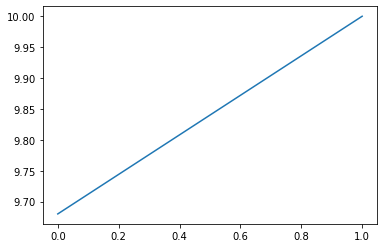

Epoch 2
-------------------------------
0
loss: 2.351776  [    0/60000]
100
loss: 2.371307  [25600/60000]
200
loss: 2.386932  [51200/60000]


KeyboardInterrupt: ignored

In [78]:
epochs = 30
history.append(test(test_dataloader, model))
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    #drawWeights(model)
    history.append(test(test_dataloader, model))
    plt.plot(np.arange(len(history)), history)
    plt.show()
